# Monitor Convergence for "the Sun"

Applying multiple convergence checks for run 6, which adopted a floating Y and alpha. Up to now, we have monitored convergence by visually inspecting trace plots. It would be useful to know if convergence has been obtained using other metrics.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Defining convergence diagnostics

(1) trace plot, (2) acceptance fraction, (3) Gelman-Rubin diagnostic, (4) autocorrelation, (5) moving average. Others to consider: Geweke diagnostic, Raferty-Lewis diagnostic, Heidelberg-Welch diagnostic, ...

In [2]:
def tracePlot(chains, labels=None, truths=None):
    n_dim = chains.shape[2]
    
    fig, ax = plt.subplots(n_dim, 1, figsize=(8., 27.), sharex=True)
    ax[-1].set_xlabel('Iteration', fontsize=20.)
    for i in range(len(ax)):
        try:
            ax[i].set_ylabel(labels[i], fontsize=20.)
        except IndexError:
            pass
        ax[i].tick_params(which='major', axis='both', length=10., labelsize=16.)
        for j in range(len(chains)):
            try:
                ax[i].plot([0, len(chains[j,:,i])], [truths[i], truths[i]], '-', lw=4, dashes=(20., 10.), 
                           c='#B22222')
            except:
                pass
            ax[i].plot(chains[j,:,i], '-', lw=1, c='#0473B3', alpha=0.5)
    fig.tight_layout()

In [3]:
def GelmanRubin(chains, labels=None):
    n_chains = chains.shape[0]
    n_iter   = chains.shape[1]/2
    n_params = chains.shape[2]
    
    # take last n samples if total was 2n
    sample = chains[:,-n_iter:,:]
    
    # compute mean of intra-chain (within) variances
    W = np.mean(np.var(sample, axis=1), axis=0)
    
    # compute mean of inter-chain (between) variances
    chain_means = np.mean(sample, axis=1)
    mean_of_chain_means = np.mean(chain_means, axis=0)
        
    B = np.empty(n_params)
    for i in range(n_params):
        B[i] = np.sum((chain_means[:, i] - mean_of_chain_means[i])**2)*n_iter/(n_chains - 1.)
    
    # estimated variance (likely an over-estimate)
    Sigma_hat_2 = ((n_iter - 1.)*W + B)/n_iter
    
    # pooled posterior variance
    Var_hat = Sigma_hat_2 + B/(n_chains*n_iter)
    
    # compute potential scale reduction factor
    PSRF = np.sqrt(Var_hat/W)
    
    return W, B, Var_hat, PSRF

## Process samples

In [4]:
#flatchain = np.genfromtxt('/Users/grefe950/Software/StarBay/interbay/logs/Sun_W0300_N0600_B0000.dat')
flatchain = np.genfromtxt('/Users/grefe950/evolve/data/mltcal/model/chains/Sun_W0300_N0600_B0000.dat')
chains = flatchain.reshape(300, -1, 9)
labels=['Mass', '[Fe/H]', 'Y', 'log(Age)', 'Distance', 'alpha', 'log(Teff)', 'log(Fbol)', 'theta']
truths = [1.0, 0.00, 0.278, np.log10(4.568e9), 5.0, 1.884, np.log10(5779.), np.log10(1.286e-6), 1.860]

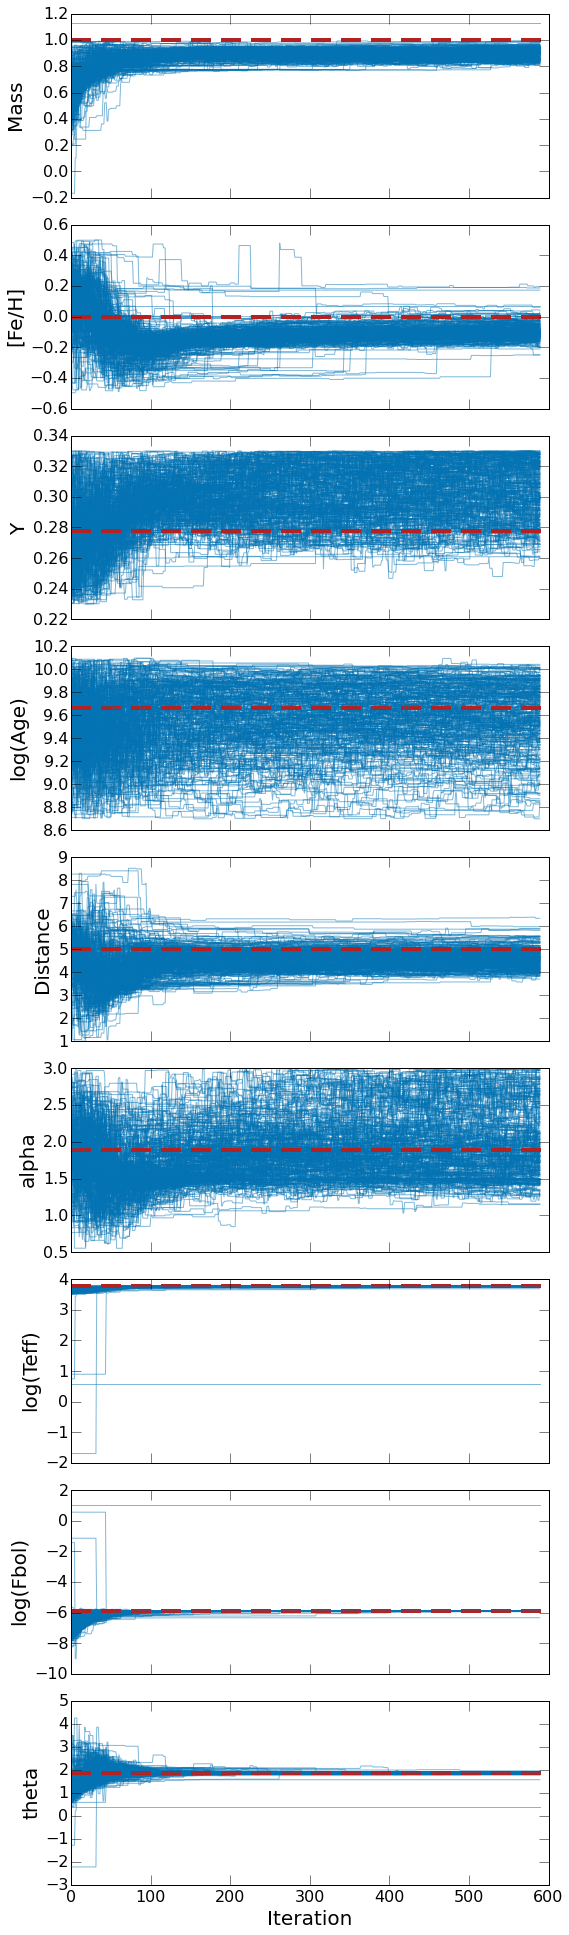

In [5]:
tracePlot(chains, labels=labels, truths=truths)

In [6]:
GelmanRubin(chains, labels=labels)

(array([  3.88200455e-04,   7.47025828e-04,   7.91417087e-05,
          7.53131848e-03,   2.38678166e-02,   3.94510910e-02,
          7.67963528e-06,   5.46826412e-05,   2.88593317e-04]),
 array([  0.38467614,   0.84478081,   0.07339414,  21.71978552,
         49.63979196,  47.46476961,   9.99067199,  47.32395751,   2.36052503]),
 array([ 0.00169522,  0.0036177 ,  0.0003285 ,  0.0813776 ,  0.19261829,
         0.20075121,  0.03398723,  0.16100943,  0.00831607]),
 array([  2.08970396,   2.20063815,   2.03733587,   3.28713042,
          2.8408115 ,   2.25579471,  66.5254116 ,  54.26263879,   5.36804151]))

Based on the trace plot, it seems as though the ensemble of chains have converged upon a solution. However, under the Gelman-Rubin diagnostic, the potential scale reduction factor is larger than one should like, that is, well above unity. 

It is therefore likely that we should continue running the chains further and continually apply a Gelman-Rubin diagnostic to assess the convergence of each parameter.

## Evolution of Potential Scale Reduction Factor


In [7]:
PSRF = np.empty((581, 9))
for i in range(10, 591):
    W, B, var_hat, PSRF[i - 10] = GelmanRubin(chains[:, :i, :]) # Note that GelmanRubin() trims the lower half

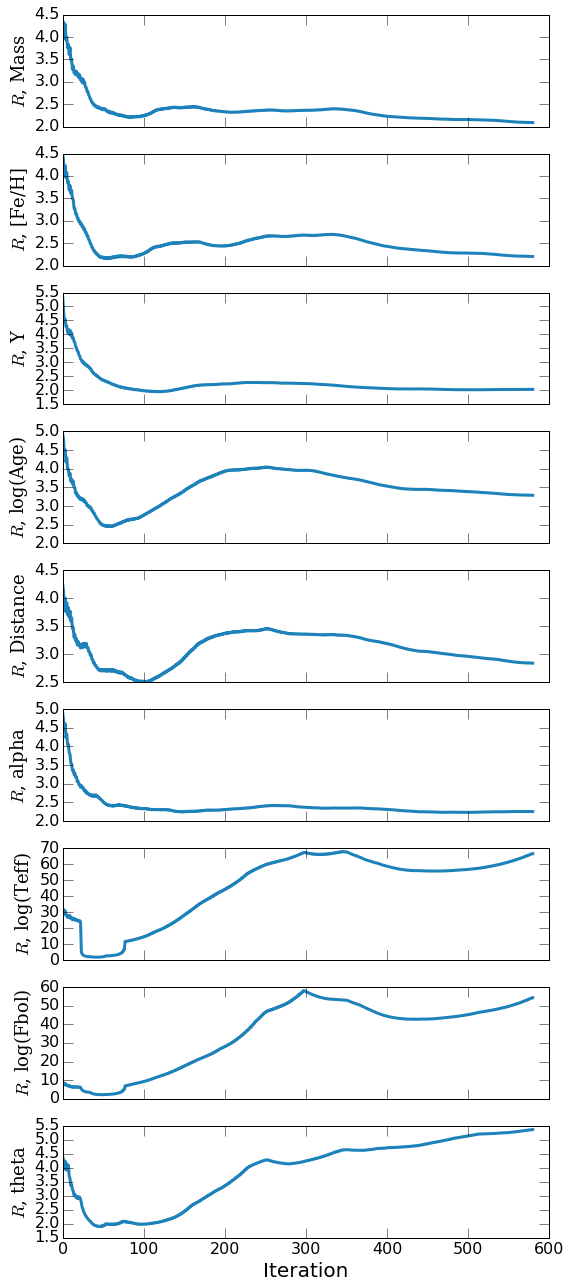

In [8]:
fig, ax = plt.subplots(9, 1, figsize=(8., 18.), sharex=True)
ax[-1].set_xlabel('Iteration', fontsize=20.)
for i in range(len(ax)):
    try:
        ax[i].set_ylabel('$R$, {:s}'.format(labels[i]), fontsize=18., family='serif')
    except IndexError:
        pass
    ax[i].tick_params(which='major', axis='both', length=10., labelsize=16.)
    ax[i].plot(PSRF[:,i], '-', lw=3, c='#0473B3', alpha=0.9)
    
fig.tight_layout()

There are clear issues with theta and Teff, which appear to possess a high level of variance, even after nearly 600 iterations. This can be traced to the presence of a couple outlier chains in the trace plots above. These chains have non-sense values for the effective temperature, bolometric flux, and angular diameter. Additional chains and interations should mitigate the presence of these outliers.

## Another Sun Run

In the interest of determining "optimal" MCMC parameters (number of walkers and iterations), I've started a new solar run. Instead of continuing the run used above (300 walkers, 600 iterations), I've started a new sampler with 1000 walkers over 500 steps. Depending on how well converged the final set of chains look, it may be worth decreasing the number of walkers and increasing the number of steps. 

Tracking the convergence of the above chains illustrated that convergence was slow, with the potential scale reduction factor slowly (albeit steadily) creeping toward acceptable values. 

In [16]:
new_flatchain = np.genfromtxt('/Users/grefe950/evolve/data/mltcal/model/chains/Sun_W1000_N0500_B0000.dat')
new_chains = new_flatchain.reshape(1000, -1, 9)

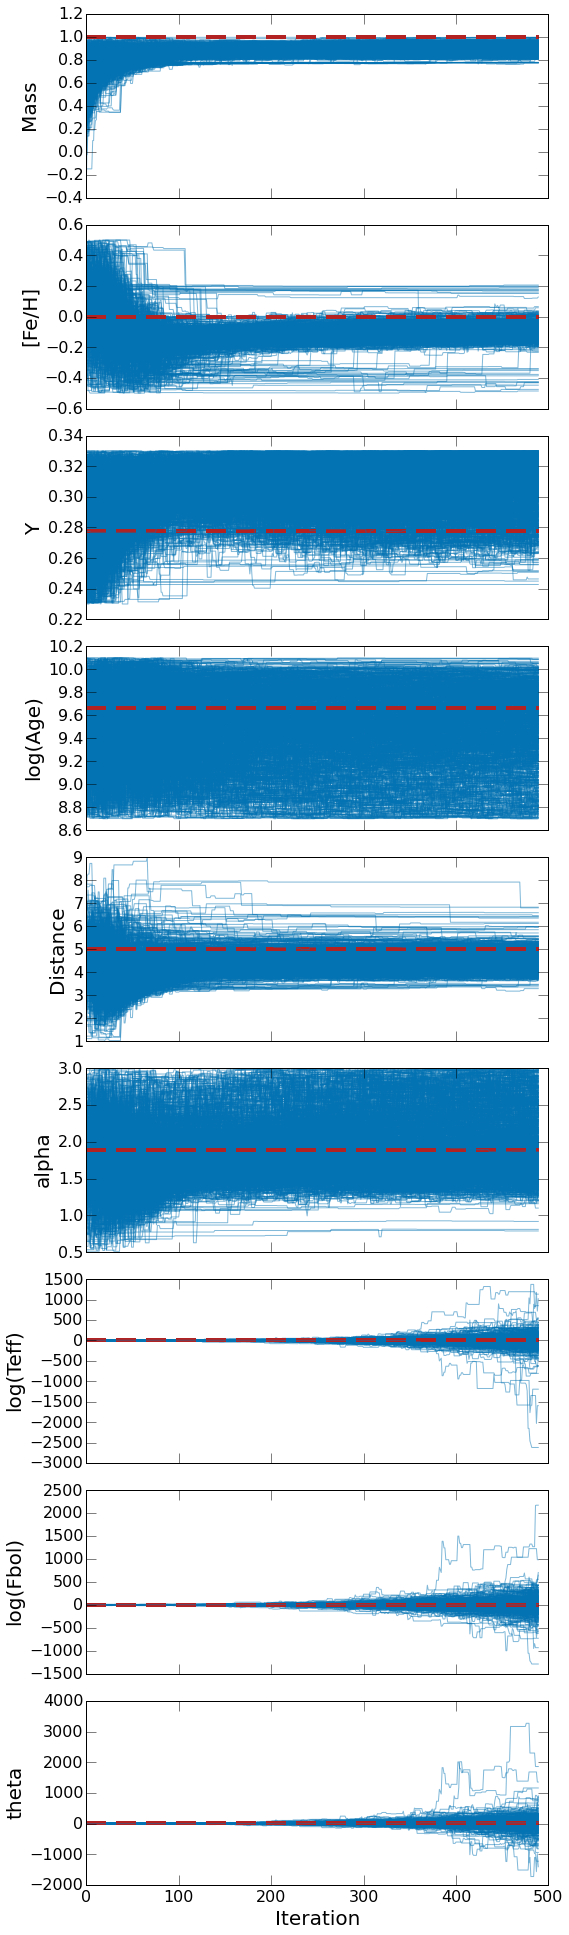

In [17]:
tracePlot(new_chains, labels=labels, truths=truths)

In [19]:
GelmanRubin(new_chains, labels=labels)

(array([  3.00644714e-04,   5.71600287e-04,   6.40183786e-05,
          7.49477493e-03,   1.80979598e-02,   3.04443901e-02,
          3.19341133e+03,   2.72328546e+03,   5.09612552e+03]),
 array([  3.33713781e-01,   8.92066662e-01,   6.72800092e-02,
          2.69895560e+01,   4.99953269e+01,   4.26581636e+01,
          5.92462074e+05,   6.16794632e+05,   1.07766582e+06]),
 array([  1.66287675e-03,   4.21399673e-03,   3.38643974e-04,
          1.17735798e-01,   2.22290712e-01,   2.04609196e-01,
          5.60100776e+03,   5.23221665e+03,   9.47835966e+03]),
 array([ 2.35181548,  2.71519408,  2.29995501,  3.96346446,  3.50465965,
         2.59244132,  1.32435878,  1.38610546,  1.36378696]))

In [20]:
new_PSRF = np.empty((481, 9))
for i in range(10, 491):
    W, B, var_hat, new_PSRF[i - 10] = GelmanRubin(new_chains[:, :i, :]) # Note that GelmanRubin() trims the lower half

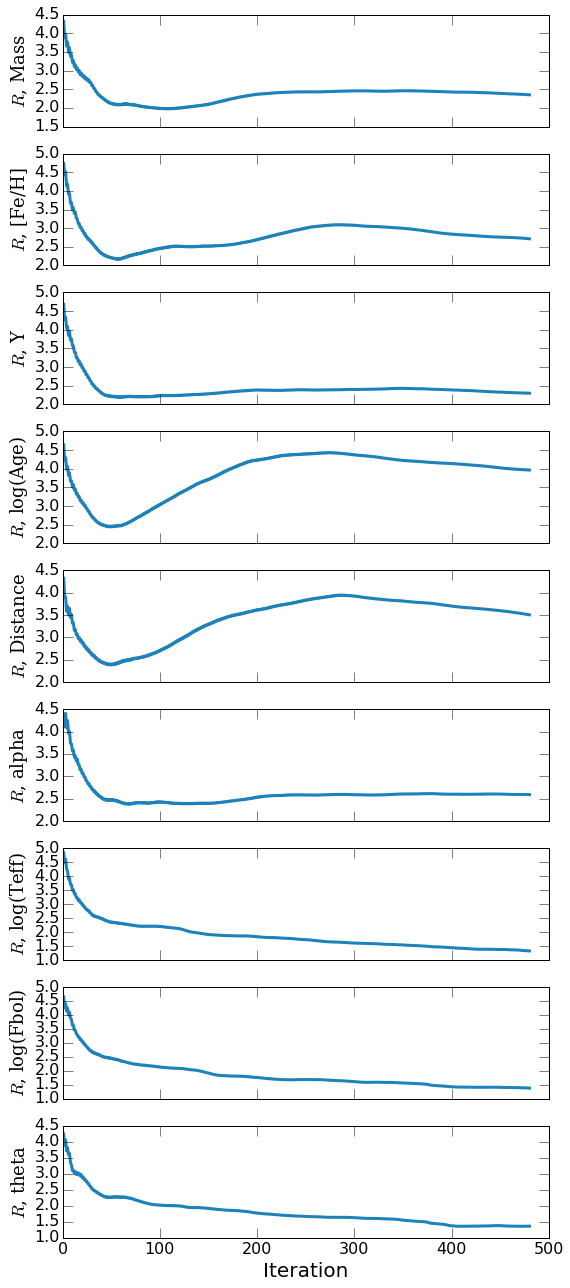

In [21]:
fig, ax = plt.subplots(9, 1, figsize=(8., 18.), sharex=True)
ax[-1].set_xlabel('Iteration', fontsize=20.)
for i in range(len(ax)):
    try:
        ax[i].set_ylabel('$R$, {:s}'.format(labels[i]), fontsize=18., family='serif')
    except IndexError:
        pass
    ax[i].tick_params(which='major', axis='both', length=10., labelsize=16.)
    ax[i].plot(new_PSRF[:,i], '-', lw=3, c='#0473B3', alpha=0.9)
    
fig.tight_layout()

---

### References

Brooks & Gelman 1998, _Journal of Computational and Graphical Statistics_, __7__, 434 &ndash; 455; [General Methods for Monitoring Convergence of Iterative Simulations](http://www.jstor.org/stable/1390675?origin=crossref)

Gelman & Rubin 1992, _Statistical Science_, __7__, 457 &ndash; 511; [Inference from Iterative Simulation Using Multiple Sequences](https://projecteuclid.org/euclid.ss/1177011136)